In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
dev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
words = open('../data/names.txt', 'r').read().splitlines()

# vocabulary of characters and mapping to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)



In [5]:
block_size = 3 #how many character are taken to predict next one
def build_dataset(words):
    inputs, labels = [],[]

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            inputs.append(context)
            labels.append(ix)
            context = context[1:] + [ix] #crop and append next character
    inputs = torch.tensor(inputs).to(dev)
    labels = torch.tensor(labels).to(dev)
    return inputs, labels

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
xtrain, ytrain = build_dataset(words[:n1])
xdev, ydev = build_dataset(words[n1:n2])
xtest, ytest = build_dataset(words[n2:])

In [6]:
n_embd = 10 #dimensionality of the character embedding vectors
n_hidden = 200 #number of neurons in a hidded layere

C = torch.randn((vocab_size, n_embd)).to(dev)
W1 = torch.randn((n_embd * block_size, n_hidden)).to(dev)
W2 = torch.randn((n_hidden, vocab_size)).to(dev) * 0.01
b2 = torch.randn(vocab_size).to(dev) * 0

bngain = torch.ones((1, n_hidden)).to(dev)
bnbias = torch.zeros((1, n_hidden)).to(dev)
bnmean_running = torch.zeros((1, n_hidden)).to(dev)
bnstd_running = torch.ones((1, n_hidden)).to(dev)


parameters = [C, W1, W2, b2, bngain, bnbias]

In [18]:
for p in parameters:
    p.requires_grad=True

In [19]:

lossi = []
max_steps = 200000
batch_size = 32
for i in range(max_steps):

        #minibatch construct
        ix  = torch.randint(0, xtrain.shape[0], (batch_size,))
        xbatch, ybatch = xtrain[ix], ytrain[ix]
        #forward pass
        embed = C[xbatch]
        embcat = embed.view(embed.shape[0], -1) #concatenate vectors

        hpreact = embcat @ W1 

        #batchnorm layer. we use batchnorm to control the statistics of activations in the neural net
        bn_stdi = hpreact.std(0, keepdim=True)
        bn_meani = hpreact.mean(0, keepdim=True)
        hpreact = bngain * (hpreact - bn_meani) / bn_stdi  + bnbias
        with torch.no_grad():
          bnmean_running = 0.999 * bnmean_running + 0.001 + bn_meani
          bnstd_running = 0.999 * bnstd_running + 0.001 * bn_stdi

        #non-linearity
        h = torch.tanh(hpreact)
        logits = h @ W2 + b2
        loss = F.cross_entropy(logits, ybatch)

        #backward pass
        for p in parameters:
            p.grad = None
        loss.backward()

        learning_rate = 0.1 if i < 100000 else 0.01
        for p in parameters:
            p.data -= p.grad * learning_rate 

        #loss statistics
        if i % 10000 == 0:
            print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        lossi.append(loss.log10().item())

        #break
print(loss.item())


      0/ 200000: 3.2801
  10000/ 200000: 2.3258
  20000/ 200000: 2.4389
  30000/ 200000: 2.0317
  40000/ 200000: 2.5201
  50000/ 200000: 2.2515
  60000/ 200000: 2.3741
  70000/ 200000: 2.0595
  80000/ 200000: 2.2587
  90000/ 200000: 2.6538
 100000/ 200000: 2.0140
 110000/ 200000: 2.4809
 120000/ 200000: 2.2026
 130000/ 200000: 2.1953
 140000/ 200000: 2.3808
 150000/ 200000: 2.2736
 160000/ 200000: 2.5935
 170000/ 200000: 2.0392
 180000/ 200000: 2.2399
 190000/ 200000: 2.2500
2.26942777633667


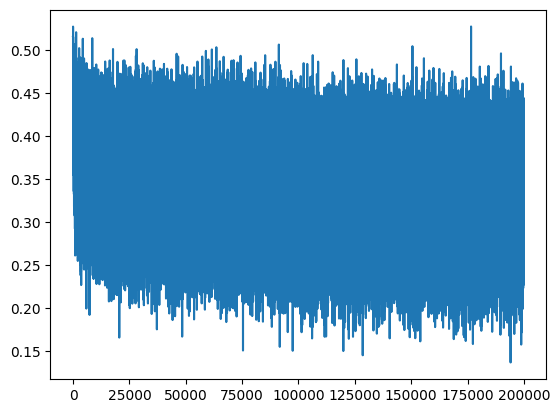

In [20]:
plt.plot(lossi)

In [21]:
# calibrate the batch norm at the end of training
with torch.no_grad():
  emb = C[xtrain]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 #+ b1
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)

In [11]:
@torch.no_grad() #disables gradient tracking
def split_loss(split):
    x, y = {
        'train': (xtrain, ytrain),
        'val': (xdev, ydev),
        'test': (xtest, ytest)
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1) #concat into (N, block_size * n_embd)
    hpreact = embcat @ W1 #+ b1
    hpreact = bngain * (hpreact - bnmean) / bnstd + bnbias

    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
split_loss('train')
split_loss('val')

train 3.2641751766204834
val 3.2640414237976074


In [12]:
#sample from model
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        embed = C[torch.tensor([context])]
        embcat = embed.view(embed.shape[0], -1)
        hpreact = embcat @ W1 + b1
        h = torch.tanh(hpreact)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

cmyzdekfzhuvaqbq.
aupdruutakxiwrh.
qgyzyy.
ghcprpbsuxbvswewrzmvvccf.
vqohhdqckmsgndyxuywcyxvhwfiepafwejoqhawf.
jlfp.
phkmyjtezyhnflmtisjaabhssnjamcwqntuqjdtxqgdncebjaj.
ocqfqojnlbhivzehdzfwfybdfyjaphbsjgjnigwktgeoifjodljnunzpiakebptphnokilltfwhm.
jbjgldvonuhwewsqvlvbalqhtiqmgddhkyewygehkjrdudkgvtnce.
tzxvhxawkssteogewmfdueppvngaebweyczhwiirrksndlvpntqerhjuhupestrxjtinzxehjqqaarzgyrjjczthstgdrmnawleeuihgctkarhxcwfcfrveuiubkljsrriiwvcchxgzueiia.
cbxfdrqqdvchunhymwd.
qlwq.
tivqcwsakbiutasojikxlidvptorovykdjkfpaozffeov.
stkxmadtbbsxfgeowupoynjagqhqtixt.
wbkcctqavgsocznbbqodibfcabhpyhqbzeodbdmgmbd.
bqdpwhnsuipnphdmkzrkj.
zlsvukikjatzhpmnzpqmsoxmyeidj.
kraltsnd.
ftqgkhwedtolqwlazcqstcygaqdcafkzrwrmthia.
kyeffrthdhmoaxfolyfzffcothbqcb.
